In [1]:
import numpy as np
import pandas as pd
import bbi
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import bioframe as bf
import cooltools
import cooltools.lib.plotting
import cooler
from matplotlib.colors import LogNorm

In [2]:
#### A way to use externel fonts in matplotlib without installing it
from matplotlib import font_manager
font_dirs = ['/users/ankit.gupta/.fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
#### A way to use externel fonts in matplotlib without installing it

mpl.rcParams['font.family'] = 'Nunito'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 2

In [3]:
microCRes = 1000
cools = {}
cools["WT"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/WT.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
cools["KO"] = cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library_group/KO.mm9.mapq_30.100.mcool::resolutions/{microCRes}")
mm9_chromsizes = bf.fetch_chromsizes('mm9')
mm9_cens = bf.fetch_centromeres('mm9') ### Mouse chromosomes are telocentric
mm9_chroms = bf.core.construction.add_ucsc_name_column(bf.make_chromarms(mm9_chromsizes,  mm9_cens))
mm9_chroms = mm9_chroms[mm9_chroms.chrom.isin(cools["WT"].chromnames)].reset_index(drop=True)

In [4]:
%%time

expectedWT = pd.read_csv(f"../microC_pileups/expected_cis_WT_group_{microCRes//1000}kb_res.tsv",sep="\t")
expectedKO = pd.read_csv(f"../microC_pileups/expected_cis_KO_group_{microCRes//1000}kb_res.tsv",sep="\t")

CPU times: user 9.67 s, sys: 784 ms, total: 10.5 s
Wall time: 11.6 s


In [5]:
repsExpectedWT = {}
repsExpectedKO = {}
for i in [1,2,3]: # replicates
    print(f"processing replicate: {i}, resolution: {microCRes}")
    repsMcool = dict(WT=cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library/WT-R{i}.mm9.mapq_30.100.mcool::resolutions/{microCRes}"), 
                       KO=cooler.Cooler(f"/groups/goloborodko/projects/lab/pavri-spt5/mm9/distiller_0.3.3/results/coolers_library/KO-R{i}.mm9.mapq_30.100.mcool::resolutions/{microCRes}"))

    repsExpectedWT[i] = pd.read_csv(f"../microC_pileups/expected_cis_WT_R{i}_{microCRes//1000}kb_res.tsv",sep="\t")
    repsExpectedKO[i] = pd.read_csv(f"../microC_pileups/expected_cis_KO_R{i}_{microCRes//1000}kb_res.tsv",sep="\t")

processing replicate: 1, resolution: 1000
processing replicate: 2, resolution: 1000
processing replicate: 3, resolution: 1000


In [6]:
expectedWT['s_bp'] = expectedWT['dist']* microCRes
expectedKO['s_bp'] = expectedKO['dist']* microCRes

for i in [1,2,3]:
    repsExpectedWT[i]['s_bp'] = repsExpectedWT[i]['dist']* microCRes
    repsExpectedKO[i]['s_bp'] = repsExpectedKO[i]['dist']* microCRes    

In [7]:
expectedWT

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg,balanced.avg.smoothed,balanced.avg.smoothed.agg,s_bp
0,chr1:0-197195432,chr1:0-197195432,0,179931,NaN,NaN,NaN,NaN,NaN,NaN,0
1,chr1:0-197195432,chr1:0-197195432,1,176467,NaN,NaN,NaN,NaN,0.000557,0.000568,1000
2,chr1:0-197195432,chr1:0-197195432,2,174684,2751437.0,9217.656853,15.750939,0.052768,0.047746,0.048664,2000
3,chr1:0-197195432,chr1:0-197195432,3,173251,1449407.0,4844.178382,8.365937,0.027960,0.027235,0.027775,3000
4,chr1:0-197195432,chr1:0-197195432,4,172018,880892.0,2927.138473,5.120929,0.017016,0.016869,0.017243,4000
...,...,...,...,...,...,...,...,...,...,...,...
2654919,chrM:0-16299,chrM:0-16299,12,5,81.0,0.043111,16.200000,0.008622,0.011480,0.003551,12000
2654920,chrM:0-16299,chrM:0-16299,13,4,69.0,0.042585,17.250000,0.010646,0.013483,0.003232,13000
2654921,chrM:0-16299,chrM:0-16299,14,3,53.0,0.032120,17.666667,0.010707,0.015982,0.002964,14000
2654922,chrM:0-16299,chrM:0-16299,15,2,31.0,0.023097,15.500000,0.011549,0.018897,0.002737,15000


In [8]:
mergedExpectedWT = expectedWT.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
mergedExpectedKO = expectedKO.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
mergedExpectedWT['balanced.avg.smoothed.agg'].loc[mergedExpectedWT['s_bp'] < 2* microCRes] = np.nan
mergedExpectedKO['balanced.avg.smoothed.agg'].loc[mergedExpectedKO['s_bp'] < 2* microCRes] = np.nan

repsMergedExpectedWT = {}
repsMergedExpectedKO = {}
for i in [1,2,3]:
    repsMergedExpectedWT[i] = repsExpectedWT[i].drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    repsMergedExpectedKO[i] = repsExpectedKO[i].drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
    repsMergedExpectedWT[i]['balanced.avg.smoothed.agg'].loc[repsMergedExpectedWT[i]['s_bp'] < 2* microCRes] = np.nan
    repsMergedExpectedKO[i]['balanced.avg.smoothed.agg'].loc[repsMergedExpectedKO[i]['s_bp'] < 2* microCRes] = np.nan

In [9]:
mergedExpectedWT

,s_bp,balanced.avg.smoothed.agg
0,0,NaN
1,1000,NaN
2,2000,4.866393e-02
3,3000,2.777535e-02
4,4000,1.724278e-02
...,...,...
197191,197191000,1.602917e-07
197192,197192000,1.602908e-07
197193,197193000,1.602899e-07
197194,197194000,1.602891e-07


In [10]:
derWT = np.gradient(np.log(mergedExpectedWT['balanced.avg.smoothed.agg']),
                  np.log(mergedExpectedWT['s_bp']))

derKO = np.gradient(np.log(mergedExpectedKO['balanced.avg.smoothed.agg']),
                  np.log(mergedExpectedKO['s_bp']))

repsDerWT = {}
repsDerKO = {}
for i in [1,2,3]:
    repsDerWT[i] = np.gradient(np.log(repsMergedExpectedWT[i]['balanced.avg.smoothed.agg']),
                  np.log(repsMergedExpectedWT[i]['s_bp']))
    repsDerKO[i] = np.gradient(np.log(repsMergedExpectedKO[i]['balanced.avg.smoothed.agg']),
                  np.log(repsMergedExpectedKO[i]['s_bp']))

/users/ankit.gupta/.local/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/users/ankit.gupta/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1074: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/users/ankit.gupta/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:1075: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))


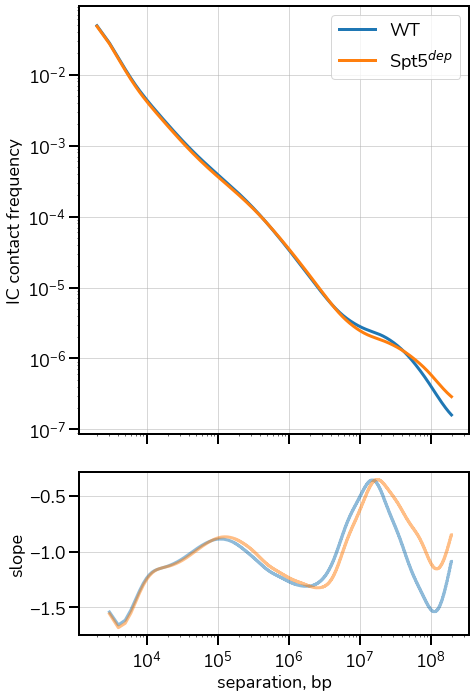

In [11]:
f, axs = plt.subplots(
    figsize=(6.5,10),
    nrows=2,
    gridspec_kw={'height_ratios':[6,2]},
    sharex=True, 
    constrained_layout=True
)
ax = axs[0]

ax.loglog(
    mergedExpectedWT['s_bp'],
    mergedExpectedWT['balanced.avg.smoothed.agg'],
    '-',
    markersize=5,
    lw=3,
    label=f"WT",
)
ax.loglog(
    mergedExpectedKO['s_bp'],
    mergedExpectedKO['balanced.avg.smoothed.agg'],
    '-',
    markersize=5,
    lw=3,
    label="Spt5$^{dep}$",
)

ax.legend()
ax.set(
    ylabel='IC contact frequency',
    # xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]
ax.semilogx(
    mergedExpectedWT['s_bp'],
    derWT,
    alpha=0.5,
    lw=3,
)
ax.semilogx(
    mergedExpectedKO['s_bp'],
    derKO,
    alpha=0.5,
    lw=3,
)

ax.set(
    xlabel='separation, bp',
    ylabel='slope')

ax.grid(lw=0.5)
# plt.savefig("ps_curve.png",dpi=300,bbox_inches="tight")
# plt.savefig("ps_curve.pdf",dpi=300,bbox_inches="tight")

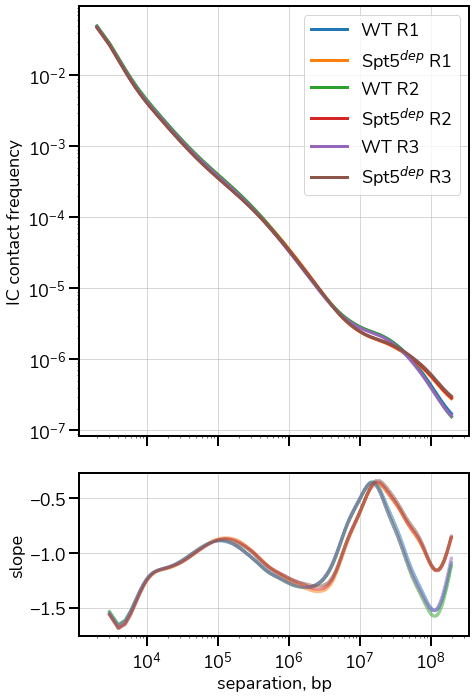

In [12]:
f, axs = plt.subplots(
    figsize=(6.5,10),
    nrows=2,
    gridspec_kw={'height_ratios':[6,2]},
    sharex=True, 
    constrained_layout=True
)
ax = axs[0]
for i in [1,2,3]:
    ax.loglog(
        repsMergedExpectedWT[i]['s_bp'],
        repsMergedExpectedWT[i]['balanced.avg.smoothed.agg'],
        '-',
        markersize=5,
        lw=3,
        label=f"WT R{i}",
    )
    ax.loglog(
        repsMergedExpectedKO[i]['s_bp'],
        repsMergedExpectedKO[i]['balanced.avg.smoothed.agg'],
        '-',
        markersize=5,
        lw=3,
        label="Spt5$^{dep}$" + f" R{i}",
    )

ax.legend()
ax.set(
    ylabel='IC contact frequency',
    # xlim=(1e3,1e8)
)
ax.set_aspect(1.0)
ax.grid(lw=0.5)


ax = axs[1]

for i in [1,2,3]:
    ax.semilogx(
        repsMergedExpectedWT[i]['s_bp'],
        repsDerWT[i],
        alpha=0.5,
        lw=3,
    )
    ax.semilogx(
        repsMergedExpectedKO[i]['s_bp'],
        repsDerKO[i],
        alpha=0.5,
        lw=3,
    )

ax.set(
    xlabel='separation, bp',
    ylabel='slope')

ax.grid(lw=0.5)
# plt.savefig("ps_curve_reps.png",dpi=300,bbox_inches="tight")
# plt.savefig("ps_curve_reps.pdf",dpi=300,bbox_inches="tight")